In [1]:
import os
#Set current location to the location of the script
os.chdir("/dust3r")
print(os.getcwd())

/dust3r


In [2]:
#Display imgs
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import open3d as o3d
import torch

from dust3r.inference import inference, inference_with_mask
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

DATA_PATH = "/dust3r/masked_dust3r/data/chicken"
device = 'cuda'
batch_size = 1
schedule = 'cosine'
lr = 0.01
niter = 300

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [3]:
model_name = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)

... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth


instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>


In [5]:
# load_images can take a list of images or a directory

images_array = []

for i in range(10):
    images_array.append(os.path.join(DATA_PATH,"masked_images/{}.jpg".format(i)))
images = load_images(images_array, size=512, verbose=True)

>> Loading a list of 10 images
 - adding /dust3r/masked_dust3r/data/chicken/masked_images/0.jpg with resolution 4000x3000 --> 512x384
 - adding /dust3r/masked_dust3r/data/chicken/masked_images/1.jpg with resolution 4000x3000 --> 512x384
 - adding /dust3r/masked_dust3r/data/chicken/masked_images/2.jpg with resolution 4000x3000 --> 512x384
 - adding /dust3r/masked_dust3r/data/chicken/masked_images/3.jpg with resolution 4000x3000 --> 512x384
 - adding /dust3r/masked_dust3r/data/chicken/masked_images/4.jpg with resolution 4000x3000 --> 512x384
 - adding /dust3r/masked_dust3r/data/chicken/masked_images/5.jpg with resolution 4000x3000 --> 512x384
 - adding /dust3r/masked_dust3r/data/chicken/masked_images/6.jpg with resolution 4000x3000 --> 512x384
 - adding /dust3r/masked_dust3r/data/chicken/masked_images/7.jpg with resolution 4000x3000 --> 512x384
 - adding /dust3r/masked_dust3r/data/chicken/masked_images/8.jpg with resolution 4000x3000 --> 512x384
 - adding /dust3r/masked_dust3r/data/chick

In [7]:
pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
output = inference(pairs, model, device, batch_size=batch_size)

view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

>> Inference with model on 90 image pairs


  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:45<00:00,  1.96it/s]


In [8]:
scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)


imgs = scene.imgs
focals = scene.get_focals()
poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks()

 init edge (7*,8*) score=6.088819980621338
 init edge (6*,7) score=4.361822605133057
 init edge (7,9*) score=4.065653324127197
 init edge (7,0*) score=3.807302474975586
 init edge (7,1*) score=3.5100393295288086
 init edge (7,2*) score=3.1660056114196777
 init edge (6,5*) score=2.8338048458099365
 init edge (5,4*) score=2.7996838092803955
 init edge (2,3*) score=2.400848865509033
 init loss = 0.003338118549436331
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 300/300 [01:01<00:00,  4.84it/s, lr=1.27413e-06 loss=0.00201427]


In [9]:
#Check if pointclouds folder exists
#If exists, delete all files in the folder
if os.path.exists("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH)):
    for file in os.listdir("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH)):
        os.remove("{DATA_PATH}/pointclouds/{file}".format(DATA_PATH=DATA_PATH, file=file))
        
if not os.path.exists("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH)):
    os.makedirs("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH))

for i in range(len(images)):
    pointcloud = pts3d[i].detach().cpu().numpy()
    pointcloud = pointcloud.reshape(-1, 3)
    color = imgs[i].reshape(-1, 3)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pointcloud)
    pcd.colors = o3d.utility.Vector3dVector(color)
    o3d.io.write_point_cloud("{DATA_PATH}/pointclouds/pointcloud{i}.ply".format(DATA_PATH=DATA_PATH, i=i), pcd)

(-0.5, 511.5, 383.5, -0.5)

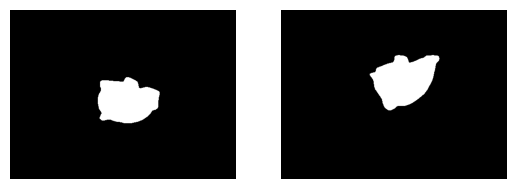

In [10]:
conf1 = confidence_masks[0].cpu().numpy()
conf2 = confidence_masks[1].cpu().numpy()

plt.subplot(1, 2, 1)
plt.imshow(conf1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(conf2, cmap='gray')
plt.axis('off')